In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Convolution2D, UpSampling2D, Reshape, core, Dropout, Cropping2D, ZeroPadding2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
import zipfile

In [3]:
!pip install keras-unet

In [4]:
from keras_unet.models import satellite_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
N_Cls = 1
ISZ = 160
smooth = 1e-12
SB = pd.read_csv('/content/drive/MyDrive/Data Vision/sample_submission.csv.zip')

In [7]:
def predict_id(id, model, trs):
    img = M(id)
    
    x = stretch_n(img)
    print(x.shape)
    #x = img.astype('float32')/2047
    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((1, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 1, 2, 3)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
#             print(tmp[j].shape)
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = np.transpose(tmp[j], (2, 0, 1))

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    
    prd[0] = prd[0] > trs[0]

    return prd[:, :img.shape[0], :img.shape[1]]

In [8]:
def stretch_n(bands, lower_percent=5, higher_percent=95):

  #out = np.zeros_like(bands)
  #print(out.shape)
  n = bands.shape[2]
  for i in range(n):
    print(i)
    y = bands[:, :, i]
    min = y.min()
    max = y.max()
    x = (y - min) / (max - min)
    if i == 0:
      out = np.expand_dims(x,2)
    else:
      out = np.concatenate([out, np.expand_dims(x,2)],2) 
        #a = 0  # np.min(band)
        #b = 1  # np.max(band)
        #c = np.percentile(bands[:, :, i], lower_percent)
        #d = np.percentile(bands[:, :, i], higher_percent)
        #t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        #t[t < a] = a
        #t[t > b] = b
        #out[:, :, i] = t
  return out.astype(np.float32)

In [9]:
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2])
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1])
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [10]:
def M(image_id):
    L, C1, C2 = 1.0, 6.0, 7.5
    zip_path = '/content/drive/MyDrive/Data Vision/sixteen_band.zip'
    tgtImg = '{}_M.tif'.format(image_id)
    with zipfile.ZipFile(zip_path) as myzip:
        files_in_zip = myzip.namelist()
        for fname in files_in_zip:
            if fname.endswith(tgtImg):
                with myzip.open(fname) as myfile:
                    img = tiff.imread(myfile)
                    img = np.rollaxis(img, 0, 3)
                    return img
#    image_r = img[..., 4]
#    image_g = img[..., 2]
#    image_b = img[..., 1]
#    nir = img[..., 7]
#    re = img[..., 5]
#    evi = np.nan_to_num(
#    (nir - image_r) / (nir + C1 * image_r - C2 * image_b + L))
#    evi = evi.clip(max=np.percentile(evi, 99), min=np.percentile(evi, 1))
#    evi = np.expand_dims(evi, 2)

#    ndwi = (image_g - nir) / (image_g + nir)
#    ndwi = np.expand_dims(ndwi, 2)

#    savi = (nir - image_r) / (image_r + nir)
#    savi = np.expand_dims(savi, 2)

            # binary = (ccci > 0.11).astype(np.float32) marks water fairly well
#    ccci = np.nan_to_num(
#    (nir - re) / (nir + re) * (nir - image_r) / (nir + image_r))
#    ccci = ccci.clip(
#    max=np.percentile(ccci, 99.9),
#    min=np.percentile(ccci, 0.1))
#    ccci = np.expand_dims(ccci, 2)
#    img2 = np.concatenate([img, evi, ndwi, savi, ccci], 2)
    

In [11]:
def predict_test(model, trs):
    print ("predict test")
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save('/content/drive/MyDrive/Data Vision/msk/10_%s' % id, msk)
        if i % 100 == 0: print (i, id)

In [12]:
def mask_for_polygons(polygons, im_size):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


In [13]:
def mask_to_polygons(mask, epsilon=5, min_area=1.):

    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours(((mask == 1) * 255).astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [14]:
def calc_jacc(model):
    img = np.load('/content/drive/MyDrive/Data Vision/data/x_tmp_%d.npy' % N_Cls)
    msk = np.load('/content/drive/MyDrive/Data Vision/data/y_tmp_%d.npy' % N_Cls)
    prd = model.predict(img, batch_size=4)
    print (prd.shape, msk.shape)
    avg, trs = [], []
    print(msk.shape)
    t_msk = msk[:, 0, :]
    t_prd = prd[:, 0, :, :]
    t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], 1)
    t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], 1)
        
    m, b_tr = 0, 0
    for j in range(10):
        tr = j / 10.0
        pred_binary_mask = t_prd > tr
        jk = jaccard_score(t_msk, pred_binary_mask)
        if jk > m:
            m = jk
            b_tr = tr
    print (0, m, b_tr)
    avg.append(m)
    trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs

In [15]:
def check_predict(id,tor):
    #model = satellite_unet(input_shape=(160, 160, 8))
    
    model = get_unet()
    model.load_weights('/content/drive/MyDrive/Data Vision/weights/unet_10_jk%.4f' % score)

    msk = predict_id(id, model, tor)
    img = M(id)

    plt.figure(figsize=(20,20))
    ax1 = plt.subplot(121)
    ax1.set_title('Image ID:6140_1_2')
    ax1.imshow(img[:, :,3], cmap=plt.get_cmap('BrBG'))
    #ax2 = plt.subplot(132)
    #ax2.set_title('predict bldg pixels')
    #ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(122)
    ax3.set_title('Predicted Building Polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))
    plt.show()
        

In [16]:
# Get patches
def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2
    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]
        sm = np.sum(ms[:, :, N_Cls-1])
        if 1.0 * sm / is2 ** 2 > tr[N_Cls-1]:
            #print(1.0 * sm / is2 ** 2)
            if aug:
              if random.uniform(0, 1) > 0.5:
                im = im[::-1]
                ms = ms[::-1]
              if random.uniform(0, 1) > 0.5:
                im = im[:, ::-1]
                ms = ms[:, ::-1]

              x.append(im)
              y.append(ms)

    x, y = 2 * np.transpose(x, (0, 1, 2, 3)) - 1, np.transpose(y, (0, 1, 2, 3))
    print (x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y))
#     y = np.delete(y, 2)
#     y = np.delete(y, 3)
    return x, y


In [17]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

In [18]:
def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

In [19]:
def jaccard_coef(y_true, y_pred):
    """
    Jaccard Index: Intersection over Union.
    J(A,B) = |A∩B| / |A∪B| 
         = |A∩B| / |A|+|B|-|A∩B|
    """
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    total = K.sum(y_true + y_pred, axis=[0, -1, -2])
    union = total - intersection

    jac = (intersection + smooth) / (union+ smooth)

    return K.mean(jac)

In [20]:
def train_net_new():
    print ("start train net")
    x_val, y_val = np.load('/content/drive/MyDrive/Data Vision/data/x_tmp_%d.npy' % N_Cls), np.load('/content/drive/MyDrive/Data Vision/data/y_tmp_%d.npy' % N_Cls)
    img = np.load('/content/drive/MyDrive/Data Vision/data/x_trn_1_NORM.npy')
    msk = np.load('/content/drive/MyDrive/Data Vision/data/y_trn_10.npy')

    x_trn, y_trn= get_patches(img, msk)
    print(y_trn[:,:,:,N_Cls-1].shape)
    model = get_unet()
    #model = satellite_unet(input_shape=(160, 160, 8))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    print("loading weights")
    #model.load_weights('C:/Users/sebas/Documents/2021-10/Vision/VC_Project/kaggle/weights/unet_10_jk0.0486')
    print("creating checkpoint")
    model_checkpoint = ModelCheckpoint('weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    print("start fitting")
    for i in range(1):
        history = model.fit(x_trn, y_trn[:,:,:,N_Cls-1] , batch_size=64, epochs=10, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        print("Finaliza entrenamiento")
        del x_trn
        del y_trn
        print("Get_patches")
        x_trn, y_trn = get_patches(img, msk)
        print("Calc_jacc")
        score, trs = calc_jacc(model)
        print ('val jk', score)
        model.save_weights('/content/drive/MyDrive/Data Vision/weights/unet_10_jk%.4f' % score)
        plot_loss(history)
        plot_accuracy(history)
        print("test mse: %.5f" % (score))
        
    return model

In [21]:
def get_unet():
    concat_axis = 3
    inputs = Input((ISZ, ISZ, 8))
    
    conv1 = Conv2D(64, (3, 3), padding="same", name="conv_layer1", activation="relu", data_format="channels_last")(inputs)
    conv1 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv3)

    up_conv3 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv3)
    ch, cw = get_crop_shape(conv2, up_conv3)
    crop_conv2 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv2)
    up8   = concatenate([up_conv3, crop_conv2], axis=concat_axis)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv8)

    up_conv8 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv8)
    ch, cw = get_crop_shape(conv1, up_conv8)
    crop_conv1 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv1)
    up9   = concatenate([up_conv8, crop_conv1], axis=concat_axis)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv9)

    ch, cw = get_crop_shape(inputs, conv9)
    conv9  = ZeroPadding2D(padding=(ch[0],cw[0]), data_format="channels_last")(conv9)
    conv10 = Conv2D(1, (1, 1), data_format="channels_last", activation="sigmoid")(conv9)
      
    model = Model(inputs=inputs, outputs=conv10)
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
def make_val():
    print ("let's pick some samples for validation")
    img = np.load('/content/drive/MyDrive/Data Vision/data/x_trn_1_NORM.npy')
    msk = np.load('/content/drive/MyDrive/Data Vision/data/y_trn_10.npy')
    
    x, y = get_patches(img, msk, amt=3000)
    y = y[:,:,:,N_Cls-1]
    np.save('/content/drive/MyDrive/Data Vision/data/x_tmp_%d' % N_Cls, x)
    np.save('/content/drive/MyDrive/Data Vision/data/y_tmp_%d' % N_Cls, y)

In [23]:
    print ("let's pick some samples for validation")
    img = np.load('/content/drive/MyDrive/Data Vision/data/x_trn_1_NORM.npy')
    msk = np.load('/content/drive/MyDrive/Data Vision/data/y_trn_10.npy')
    
    x, y = get_patches(img, msk, amt=3000)
    y = y[:,:,:,N_Cls-1]


let's pick some samples for validation
(72, 160, 160, 8) (72, 160, 160, 10) 1.0 -1.0 1.0 0.0


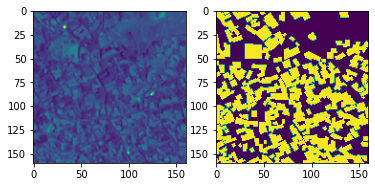

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(x[20,:,:,7])
plt.subplot(1, 2, 2)
plt.imshow(y[20,:,:])


In [25]:
make_val()

let's pick some samples for validation
(67, 160, 160, 8) (67, 160, 160, 10) 1.0 -1.0 1.0 0.0


start train net
(248, 160, 160, 8) (248, 160, 160, 10) 1.0 -1.0 1.0 0.0
(248, 160, 160)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 8) 0                                            
__________________________________________________________________________________________________
conv_layer1 (Conv2D)            (None, 160, 160, 64) 4672        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 64) 36928       conv_layer1[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 80, 64)   0           conv2d[0][0]                     
______

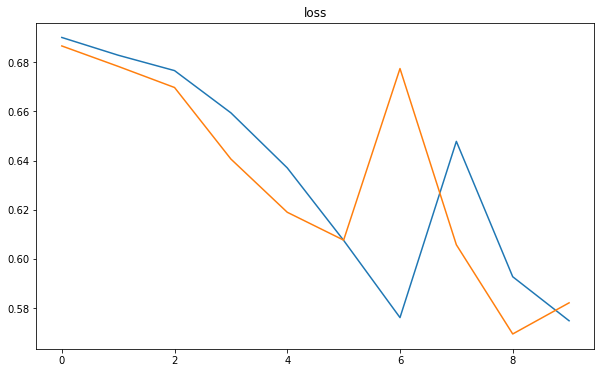

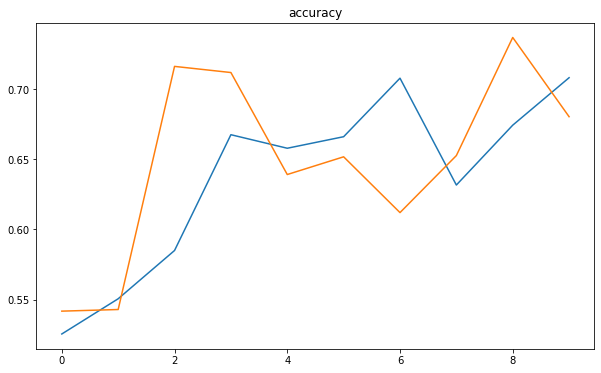

In [26]:
model = train_net_new()

In [27]:
score, trs = calc_jacc(model)

(67, 160, 160, 1) (67, 160, 160)
(67, 160, 160)
0 0.516057091882248 0.5


In [28]:
#predict_test(model, trs)

(837, 849, 8) 6010_1_2 1 0
(837, 849, 8) 6010_4_2 1 0
(837, 848, 8) 6010_4_4 1 0
(837, 848, 8) 6040_1_0 1 0
(837, 848, 8) 6040_1_3 1 0
(837, 848, 8) 6040_2_2 1 0
(837, 846, 8) 6040_4_4 1 0
(837, 851, 8) 6060_2_3 1 0
(838, 835, 8) 6070_2_3 1 0
(837, 848, 8) 6090_2_0 1 0
(837, 848, 8) 6100_1_3 1 0
(837, 848, 8) 6100_2_2 1 0
(837, 848, 8) 6100_2_3 1 0
(837, 849, 8) `6110_1_2` 1 0
(837, 849, 8) 6110_3_1 1 0
(837, 849, 8) 6110_4_0 1 0
(837, 851, 8) 6120_2_0 1 0
(837, 851, 8) 6120_2_2 1 0
(837, 849, 8) 6140_1_2 1 0
(837, 849, 8) 6140_3_1 1 0
(837, 851, 8) 6150_2_3 1 0
(837, 848, 8) 6160_2_1 1 0
(837, 848, 8) 6170_0_4 1 0
(837, 848, 8) 6170_2_4 1 0
(837, 848, 8) 6170_4_1 1 0

0
1
2
3
4
5
6
7
(837, 849, 8)


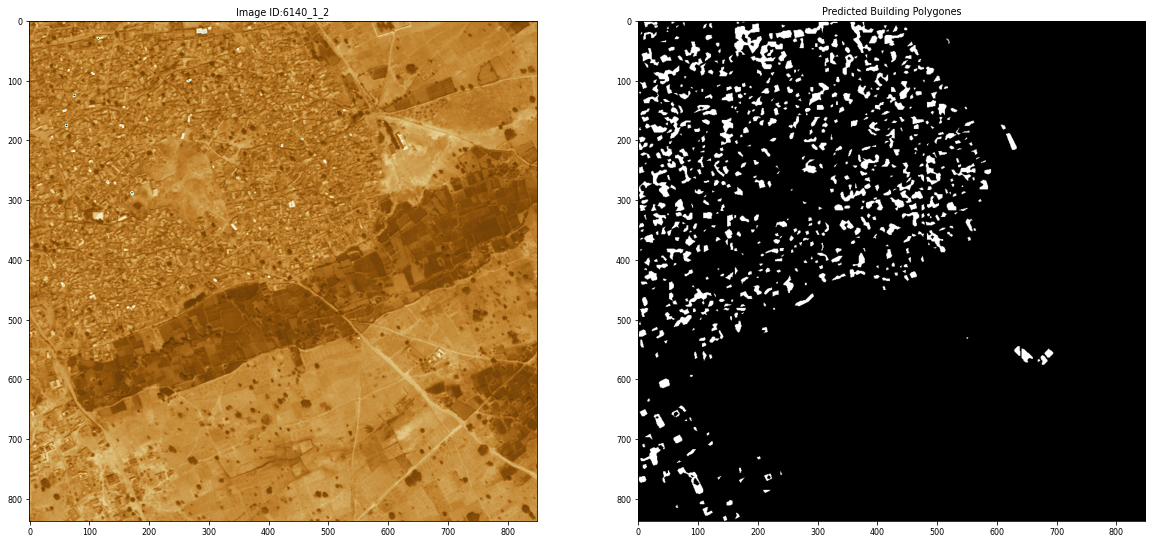

In [41]:
check_predict('6110_1_2',[0.8])

Clase 1 de edificios con x_trn funciona bien 
Clase 8 de lagos no funciona hermosa pero tiene buenos resultados con la DIFF

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f5c3c18b5d0>)

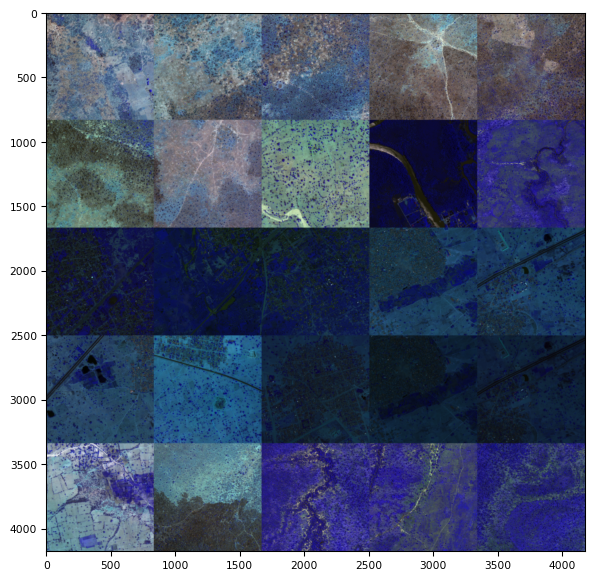

In [30]:
tiff.imshow(img[:,:,[1,4,6]])